In [17]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull, convex_hull_plot_2d

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from multiprocessing import Pool
from glob import glob

In [18]:
def clustering(A,eps):
    """
    Apply DBSCAN to every slice of point cloud.
    Get the weld surface.

    Parameters
    ----------
    A : ndarray
        array of shape (N,3)
        point cloud before clustering filter
    eps: float
        epsilon distance --> look in sklearn DBSCAN documentation

    Returns
    -------
    A_filtered : ndarray
        array of shape (N,3)
        point cloud after clustering filter
    """
    
    # transform to dataFrame for groupby-function
    df = pd.DataFrame({'X':A[:,0],'Y':A[:,1],'Z':A[:,2]})

    # Extract 'Y' and 'Z' columns as input for DBSCAN
    features = df[['Y', 'Z']]
    
    # normalize data
    scaler = StandardScaler().fit(features)
    features = scaler.transform(features)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=3,n_jobs=-1)
    labels = dbscan.fit_predict(features)

    # Replace -1 with 4 (sorting don't like -1)
    labels[labels == -1] = max(labels)+1

    # Add DBSCAN labels to the DataFrame
    df['labels'] = labels

    # Calculate average 'Z' value for each label
    label_avg_z = df.groupby('labels')['Z'].median()
    sorted_labels = label_avg_z.sort_values().index
    df['sorted_labels'] = df['labels'].map({label: i for i, label in 
                                                        enumerate(sorted_labels)})
    # # Plot the results
    # x_value = df.X.mean()
    # if x_value == df.X[int(len(df.index)/2)]:
    #     plt.scatter(df['Y'], df['Z'], 
    #                 c=df['sorted_labels'], cmap='viridis')
    #     plt.xlabel('Y')
    #     plt.ylabel('Z')
    #     plt.axis('equal')
    #     plt.title(f'Cluster Plot for x = {x_value} mm')
    #     plt.show()

    # append weld surface points to mask
    sorted_labels_list = df['sorted_labels'].tolist()       
    mask = [val == max(sorted_labels_list) for val in sorted_labels_list]
    
    # get weld surface
    return A[mask]

In [19]:
def get_area(arr0,arr1,min_distance,eps,plot_hull):
    """
    Compute area between two layer for a slice.
    2. Apply filtering
    3. Compute volume
    4. Plot

    Parameters
    ----------
    arr0 : ndarray
        array of shape (N,3)
        point cloud of lower layer
    arr1 : ndarray
        array of shape (N,3)
        point cloud of upper layer
    min_distance: float
        minimum distance for points from the two layer
    eps: float
        epsilon distance for DBSCAN
    plot_hull: bool
        if True, plots convex hull around slice
        
    Returns
    -------
    A : float
        area of slice
    """
    # 1.1 Preprocessing

    try:
        # 2.1 filter out similar points from both arrays
        # min_distance = 0.2
        arr0_filtered = arr0[np.all(cdist(arr0, arr1) >= min_distance, axis=1)]
        arr1_filtered = arr1[np.all(cdist(arr1, arr0) >= min_distance, axis=1)]

        # 2.2 filter points based on density
        arr0_filtered = clustering(arr0_filtered,eps)
        arr1_filtered = clustering(arr1_filtered,eps)

        # 2.3 remove points from arr0 that are outside of arr1 in y-dir (melt pool downslide)
        arr0_2D,arr1_2D = arr0_filtered[:,1:],arr1_filtered[:,1:] # make 2D - remove x column
        ymin,ymax = np.min(arr1_2D[:,0]), np.max(arr1_2D[:,0]) 
        arr0_2D = arr0_2D[(arr0_2D[:,0] < ymax) & (ymin < arr0_2D[:,0])]

        # 3.1 get area - A0 - lower layer
        if len(arr0) < 5: # zero layer with three points
            arr0_2D = arr0[:,1:] # no filter needed
        hull_A0 = ConvexHull(arr0_2D)
        A0 = hull_A0.volume
        
        # 3.2 get area - A1 - combined layers
        arrC = np.vstack((arr0_2D,arr1_2D)) # combined array of two layers
        hull_A1 = ConvexHull(arrC)
        A1 = hull_A1.volume # for 2D data hull.volume = area
        
        # 3.3 get area - A - only upper layer
        A = A1 - A0
        
        # # 3.4 get volume
        # V = A * 1 # mm³/mm, specific volume per mm 

        # # 3.5 get mass
        # density = 7.98 * 1e-3 # g/mm³
        # M = density * V # g/mm or kg/m

        # 4. plot points and convex hull
        if plot_hull == True:
            fig = plt.figure(figsize=(4.24*1.5,3*1.5))
            ax = plt.subplot(111)
            ax.plot(arr0_2D[:,0],arr0_2D[:,1],'C0.') # lower array points
            ax.plot(arr1_2D[:,0],arr1_2D[:,1],'C1.') # upper layer points
            convex_hull_plot_2d(hull_A0, ax=ax)
            convex_hull_plot_2d(hull_A1, ax=ax)

            # ax.plot(arrC[hull_A0.vertices,0], arrC[hull_A0.vertices,1], 'C7--', lw=1) # lower array hull
            # ax.plot(arrC[hull_A1.vertices,0], arrC[hull_A1.vertices,1], 'C7--', lw=1) # upper layer hull
            ax.set_xlabel('y [mm]')
            ax.set_ylabel('z [mm]')
            ax.grid(True)
            ax.axis('equal')
            plt.show()

    except: 
        A = np.nan # if errors occur, make area = 0
        print('error')

    return A

# 1. load data

In [20]:
if __name__ ==  '__main__': 
    t0 = time.time()

    # load all scans of a specimen
    data_dir = r"C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V03"
    npy_files = glob(os.path.join(data_dir, "layer***.npy"))
    with Pool(processes=len(npy_files)) as pool:
        arr_list = pool.map(np.load, npy_files)
    print('read finished after: ' + str(np.round(time.time()-t0, 1)) + ' s')

read finished after: 1.1 s


# 2. get area at cross-section

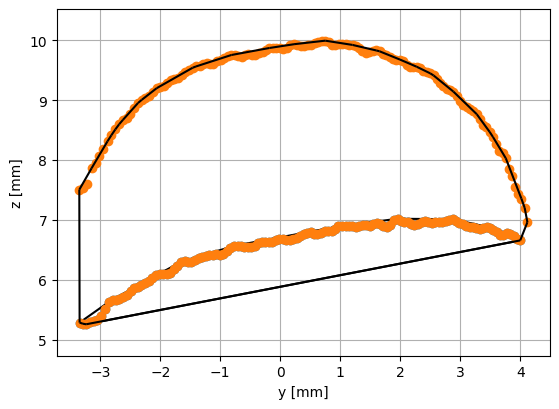

area = 20.104 mm²


In [21]:
# round list
arr_list = [np.round(arr, 3) for arr in arr_list]

# get data for one x
x = 80 # target x-value of slice
diff_threshold = 1e-3  # Define the threshold for considering the difference as "close"
filtered_list = []
for arr in arr_list:
    close_rows = arr[arr[:,0]==x]
    filtered_list.append(close_rows)

# get two layers
arr0 = filtered_list[2]
arr1 = filtered_list[3]

A = get_area(arr0,arr1,min_distance=0.2,eps=0.5,plot_hull=True)
print('area = '+str(np.round(A,3))+' mm²')

# 3. add zero layer before first scan

In [22]:
# use first laser scanned layer as basis
a0 = arr_list[0]

# only use rows with ymin and ymax
ux = np.unique(a0[:,0])
y = pd.Series(a0[:, 1])
ymin = np.array(y.groupby(a0[:, 0]).min())
ymax = np.array(y.groupby(a0[:, 0]).max())

# make layer0 - clockwise point order
a0_1_ymin = np.column_stack((ux,ymin,np.zeros_like(ux)))    # 1st point
a0_2_ymax = np.column_stack((ux,ymax,np.zeros_like(ux)))    # 2nd point
a0_3_ymin = np.column_stack((ux,ymin,np.zeros_like(ux)+1))  # 3rd point

layer0 = np.vstack((a0_1_ymin,a0_2_ymax,a0_3_ymin))

# add lyer0 at the beginning of array list
arr_list = [layer0] + arr_list

# 4. get area of every slice

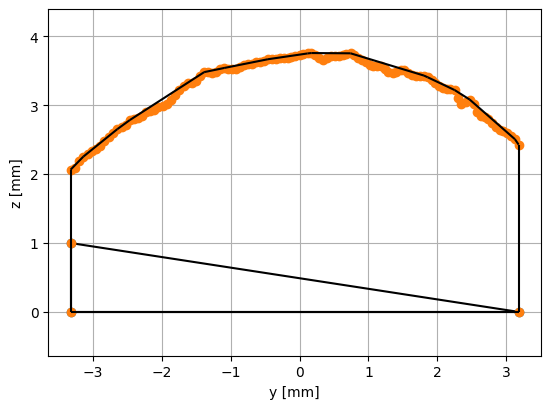

area = 17.988627499999996 mm²


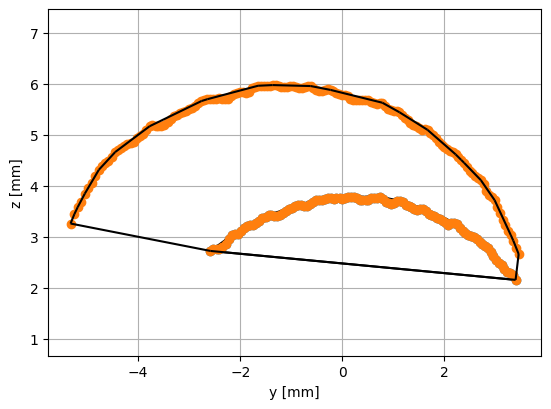

area = 16.771330000000003 mm²


In [23]:
# TESTING: only analyse two specimen
arr_list = arr_list[:3]

# loop through layers
for i, arr in enumerate(arr_list[:-1]):  
    ux0 = np.unique(arr[:,0])
    ux1 = np.unique(arr_list[i+1][:,0])
    ux = np.intersect1d(ux0,ux1)

    # loop through slices
    A_list = []
    for x in ux:
        if x == ux[900]:
            arr0 = arr_list[i]
            arr0 = arr0[arr0[:,0]==x]
            arr1 = arr_list[i+1]
            arr1 = arr1[arr1[:,0]==x]
    
            A = get_area(arr0,arr1,min_distance=0.2,eps=0.5,plot_hull=True)
            print('area = '+str(A)+' mm²')
        else:
            A = get_area(arr0,arr1,min_distance=0.2,eps=0.7,plot_hull=False)
        A_list.append(A)


In [24]:
# arr_list = arr_list[:4]
# arr_loop = arr_list[:-1]

# for i, arr in enumerate(arr_loop): # loop through layers
#     ux0 = np.unique(arr[:,0])
#     ux1 = np.unique(arr_list[i+1][:,0])
#     ux = np.intersect1d(ux0,ux1)


#     Areas = []
#     for x in ux: # loop through slices
#         arr0 = arr_list[i]
#         arr0 = arr0[arr0[:,0]==x]
#         arr1 = arr_list[i+1]
#         arr1 = arr1[arr1[:,0]==x]

#         fig = plt.figure(figsize=(4.24*1.5,3*1.5))
#         ax = plt.subplot(111)
#         ax.plot(arr0[:,1],arr0[:,2],'.')
#         ax.plot(arr1[:,1],arr1[:,2],'.')
#         plt.show()

#         # if len(arr0)>10 & len(arr1)>10: # array of slice must have at least n points
#         if x == ux[400]:
#             A = get_area(arr0,arr1,min_distance=0.2,plot_hull=True)
#         else:
#             A = get_area(arr0,arr1,min_distance=0.2,plot_hull=False)
#             print(A)
#     Areas.append(A)